# 1. Mintavételezés generatív modellből

## 1.1 Mixture of Gaussians modell

Egy mixture of Gaussians (MoG) modellt fogunk használni, amelyben egy rejtett és egy megfigyelt változó található. A rejtett változó prior eloszlása kategorikus, ami egy $k$-oldalú (tetszőlegesen cinkelt) dobókockaként képzelhető el.

$$p(z) = \mathrm{Categorical}(r)$$

$$ z \in \lbrace 0,1 \rbrace^k,\; r \in \left[ 0,1 \right]^k$$

Az $r$ paraméter egy $k$ elemű vektor, ami a cinkelést adja meg. A megfigyelt változó pedig Gauss eloszlású, amelynek átlagvektora és kovarianciamátrixa $z$-től függ.

$$p(x \mid z) = \mathcal{N}(\mu_z, C_z)$$

$$ x \in \mathbb{R}^d,\; \mu_i \in \mathbb{R}^d,\; C_i \in \mathbb{R}^{d \times d}$$

## 1.2 Grafikus modellek ábrázolása

A grafikus modell kirajzolásához a Daft csomagot fogjuk használni, ami nem a Colaboratory jupyter futtatókörnyezetben alapértelmezetten elérhető csomagok egyike, ezért telepítenünk kell. A python csomagtelepítő rendszere a pip, amelyet a parancssori utasítások jupyter környezetből való elérésére szolgáló `!` segítségével használhatunk. Telepítsük föl a csomagot és importáljuk be. A betűméret állításához szükség lesz még a `matplotlib` plottoláshoz való csomag `rc` alcsomagjára is. Ahhoz, hogy a jupyter környezetben megjelenjenek az ábrák, meg kell hívnunk egy ún. magic functiont is, amelyek a `%` szimbólumról ismerhetők fel.

In [7]:
!pip install daft
import daft
from matplotlib import rc
%matplotlib inline

A Dafthoz leírás itt található: [http://daft-pgm.org/](http://daft-pgm.org/). Először létrehozunk egy PGM (probablisztikus grafikus modell) objektumot, aminek megadjuk a rajz méretét. Ezután hozzáadhatunk változókat (node), kapcsolatokat (edge) és plate-eket is, majd renderelhetjük az ábrát. A nem valószínűségi változó paramétereket a kör lehagyásával a `plot_params={"ec": "none"}` paraméter megadásával jelölhetjük.

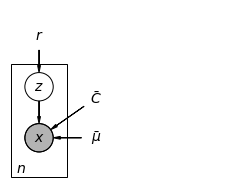

In [11]:
rc("font", family="serif", size=14)
pgm = daft.PGM((4, 3), origin=(0.15, 0.15))
pgm.add_node(daft.Node("x", r"$x$", 0.65, 0.9, observed=True))
pgm.add_node(daft.Node("mu", r"$\bar{\mu}$", 1.65, 0.9, observed=False, plot_params={"ec": "none"}))
pgm.add_node(daft.Node("C", r"$\bar{C}$", 1.65, 1.6, observed=False, plot_params={"ec": "none"}))
pgm.add_node(daft.Node("z", r"$z$", 0.65, 1.8, observed=False))
pgm.add_node(daft.Node("r", r"$r$", 0.65, 2.7, observed=False, plot_params={"ec": "none"}))
pgm.add_plate(daft.Plate([0.15, 0.2, 1., 2],label=r"$n$"))
pgm.add_edge("z","x")
pgm.add_edge("mu","x")
pgm.add_edge("C","x")
pgm.add_edge("r","z")
pgm.render()

## 1.3 A MoG modell felparaméterezése

Ehhez importáljuk be a `numpy` csomagot és abból a `random` nevű, véletlenszámgeneráláshoz való alcsomagot is rövidített nevet definiálva hozzájuk. Ezután adjuk meg a modell hiperparamétereit, amelyek a komponensek száma, $k$, és a megfigyel változó dimenziója. A modell paraméterei a komponensek relatív gyakorisága és a kompnensekhez tartozó átlagvektorok és kovarianciamátrixok. Ezeket megadhatjuk közvetlenül, vagy generálhatjuk véletlenszerűen. 

In [59]:
import numpy as np
import numpy.random as rnd

k = 3
dim_x = 2

# values for parameters - we can generate them randomly from using the appropriate distributions
# the parameter vector of a categorical distribution can be generated from a Dirichlet distribution
r = rnd.dirichlet(np.ones(k))
print('r',r)

# the mean vector of a Gaussian can be generated from a standard normal distribution and the covariance 
# matrix of the Gaussian can be generated from a random matrix as A times A transpose
mu = [] # empty list
C = []
for c in range(k):
    mu.append(rnd.normal(size=dim_x))
    A = rnd.normal(size=(dim_x,dim_x))
    C.append(np.dot(A,A.transpose()))
print('means',mu)
print('covariances',C[0][0,1],C[1][0,1],C[2][0,1])

r [ 0.3843779   0.09131775  0.52430435]
means [array([ 0.24453827,  1.62114703]), array([-0.24567712, -0.69381178]), array([ 1.10597726,  0.81876055])]
covariances 3.68326951886 0.0328820340148 0.449836287304


## 1.4 Modell prediktív eloszlásának ábrázolása

Ehhez importáljuk be a plottoláshoz leggyakrabban használt `pyplot` alcsomagot a `matplotlib`-ből, valamint a Gauss eloszlások sűrűségfüggvényét a `scipy` csomag `stats` alcsomagából, rövidített néven. Definiáljunk rácspontokat, amelyeken kiszámoljuk a MoG sűrűségfüggvény értékét, majd készítsünk szintvonalábrát belőlük.

$$p(x) = \sum_{i=1}^k r_i \mathcal{N}(\mu_i,C_i)$$

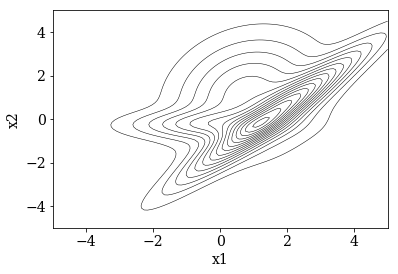

In [60]:
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as gauss

# plotting the predictive distribution
gridPoints = 100
gridMax = 5
gridMin = -gridMax
xi = np.linspace(gridMin, gridMax, gridPoints)
yi = np.linspace(gridMin, gridMax, gridPoints)
p_x = np.zeros((gridPoints,gridPoints))
for i in range(gridPoints):
    for j in range(gridPoints):
        p_x[i,j] = 0
        for c in range(k):
            p_x[i,j] += r[c] * gauss.pdf([xi[i], yi[j]], mu[c], C[c])
plt.contour(xi, yi, p_x, 15, linewidths=0.5, colors='k')
plt.xlabel('x1')
plt.ylabel('x2')

## 1.5 Mintavételezés a modell prediktív eloszlásából

Ezt az ancestral sampling nevű eljárással tehetjük meg. Először a rejtett változó prior eloszlásából veszünk mintát (a kategorikus eloszlás a multinomiális speciális esete). Ezután ezekre a mintákra kondicionálva, a megfelelő komponensparamétereket használva vegyük a megfigyelt változó mintáit.

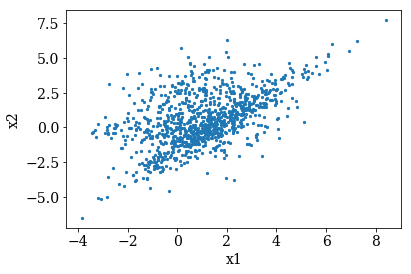

In [61]:
nSamp = 1000
# sampling from the categorical distribution for z
z_samples = rnd.multinomial(1,r,size=nSamp)

# sampling for the Gaussian conditional for x
x_samples = np.zeros((nSamp,dim_x))
for i in range(nSamp):
    # convert the vector-valued z to a single integer
    actComp = np.where(z_samples[i,:] == 1)[0][0]
    x_samples[i,:] = rnd.multivariate_normal(mu[actComp],C[actComp])
plt.scatter(x_samples[:,1],x_samples[:,0],marker='o', s=5)
plt.xlabel('x1')
plt.ylabel('x2')